# 2D Layered Surface Detection

In this tutorial we are going to look at the layered surface detection tool and see how it can be used find layers in 2D images. We will learn the following:

1. Use the slgbuilder package to find the surfaces in images.
2. Create and use layered regions to segment synthetic data.
3. Use layered boundaries to detect and segment some real-world data.

See the Github for the layered surface tool here: [slgbuilder](https://github.com/Skielex/slgbuilder)

Let's begin by importing the required python libraries that we will need for this tutorial.

In [1]:
# Standard python mathematical library
import numpy as np 

# Used for displaying our images and making graphs
import matplotlib.pyplot as plt
from matplotlib import gridspec

# Used to read in image files
from skimage.io import imread

# The main tool used for layered surface segmentation
from slgbuilder import GraphObject, MaxflowBuilder

# A set of helper functions that this notebook uses
import utilsLS as helpers

## A note on preprocessing

Depending on the dataset you are using, you may need to do some preprocessing on the images prior to using the layered surface detection tool. The layered surface detection tool works best on images with surfaces that are oriented horizontally in the image.

## 1 Segmenting synthetic data using region costs

The first thing we will do is look at how we can use the tool to detect surfaces using layered regions. Before we can start experimenting with our tool we first need to generate some synthetic data. Below there are four sliders you can play with to generate some unique synthetic data to experiment with.

- The # of layers defines the maximum number of layers the data will have
- The smoothness factor determines how smooth the boundaries are between these layers
- The minimum distance is the minimum amount of space between any two layer boundaries
- The blurring is the how blended together the layers are in the image

Be aware that everytime a slider is moved new data is randomly generated. You may now experiment with this a bit until you find something you want to work with. For now, stick with just 2 or 3 layers.

In [2]:
synthetic_widget = helpers.create_synthetic_data_widget()
display(synthetic_widget)

interactive(children=(IntSlider(value=2, continuous_update=False, description='# of layers', max=6, min=2), In…

Once you have generated some synthetic data we can go ahead in try to detect these layers using the layer surface detection algorithm.

Let's retrieve the synthetic data and ground truth images from widget above.

In [10]:
synthetic_data, ground_truth = synthetic_widget.result

### 1.1 Cost maps

When working with the layered surface detection tool we need to generate cost maps for the layers we want to find. Cost maps are images of the same dimension as the input image where the region we are looking for has the lowest intensity and all the other regions have a higher intensity.

These cost maps can be generated in a variety of ways. There is no single correct way to generate the cost maps, it depends on your data and what you are trying to segment. For our relatively simple example we compute the cost maps using the formula,

$$C_{i} = (I - \mu_{i})^2$$

where $C_i$ is the cost map for the current region, i, $I$ is the image and $\mu_{i}$ is the mean value of the current region, i.

You may have noticed that this formula requires the mean value of each of the regions we want to separate. We will estimate these means below.

### 1.2 Estimating region means
In most real-world scenarios we do not have the region means readily available. Therefore we need to manually estimate these means. This can be done by simply selecting a region of interest and computing the mean value in that region.

To simplify this process, I have created this small widget that you can use to estimate the region means. To use the tool simply paint a portion of the region on the image which you would like to find the mean of and click the calculate mean button. This will display the mean value of this painted region right below the widget. Click the clear button to erase anything you have painted on the image.

In [11]:
estimator_tool = helpers.MeanEstimatorTool(synthetic_data)

interactive(children=(IntSlider(value=20, description='Brush size', max=20, min=2), Output()), _dom_classes=('…

Button(description='Calculate mean', style=ButtonStyle())

Button(description='Clear', style=ButtonStyle())

MultiCanvas(height=256, width=256)

The larger region you paint the more accurate the region mean will be, however given the simplicity and uniformity of the synthetic data we generated a single dot should be enough. The idea is to capture the variability of the your data in the annotation process.

Save the means into a list ordered from the bottom most region to the top in the image. The first element in the list below is the region mean for the bottom most layer in the image and the last is the region mean of the top most layer.

In [13]:
region_means = [140.7043, 127.7381, 142.3643]

### 1.3 Generating the cost maps
Now we will generate the cost maps with the formula we talked about earlier.

In [14]:
n_layers = len(region_means)
cost_maps = []
for i in range(n_layers):
    cost_map = (synthetic_data - region_means[i]) ** 2
    cost_maps.append(cost_map)

Let's take a look at our cost maps.

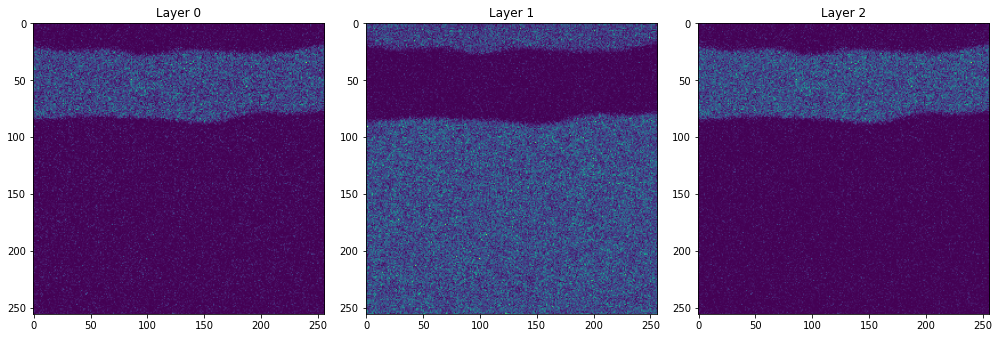

In [15]:
cols = 3
rows = int(np.ceil(n_layers / cols))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize=(14,10))
for i in range(n_layers):
    ax = fig.add_subplot(gs[i])
    ax.set_title(f'Layer {i}')
    ax.imshow(cost_maps[i])
    
fig.tight_layout()

### 1.4 Detecting the layers

Now it is time to detect the layers.

In [16]:
# Create a MaxFlowBuilder object
builder = MaxflowBuilder()

# Create a list of GraphObject layers using our image
layers = []
for i in range(n_layers-1):
    layers.append(GraphObject(cost_maps[i]))
builder.add_objects(layers)

# Add region cost layers
for i in range(n_layers-1):
    builder.add_layered_region_cost(layers[i], cost_maps[i], cost_maps[i+1])

# Add a smoothness requirement
builder.add_layered_smoothness(delta=1)

# Add constraints to the distance between the layers
for i in range(len(layers)-1):
    builder.add_layered_containment(layers[i], layers[i+1])

# Find the maximum flow
flow = builder.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 10459449


Let's see what we have detected.

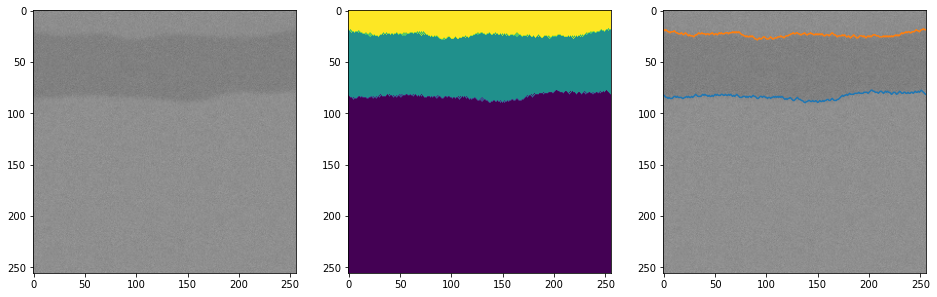

In [17]:
segmentations = [builder.what_segments(l).astype(np.int32) for l in layers]
segmentation_lines = [np.argmin(s, axis=0) - 0.5 for s in segmentations]
helpers.display_results(synthetic_data, segmentations, segmentation_lines)

## 2 Segmenting real data using boundary costs
In this section we will look into how to use boundary costs when our data consists of thin lines we would like to find.

First lets load and take a quick look at the image we will be working with.

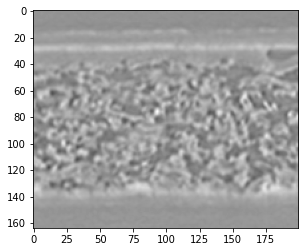

In [18]:
# Load image
image_data = imread('data/layer2D.png').astype(np.int32)

# Display image
plt.imshow(image_data, cmap='gray', vmin=0, vmax=255)
plt.show()

### 2.1 Detecting only one layer

Let's begin by trying to detect just one layer and see what we can find. Remember that we detect surfaces by creating cost maps where the region we would like to detect has the lowest values. In the case here, we would like to detect the brightest regions defined by the lines.

For this image, a good cost map could simply be the inverse of this image as that would make the lines we are looking for dark.

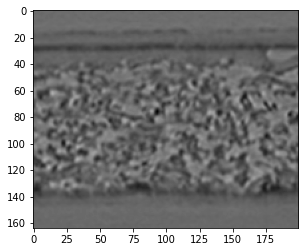

In [19]:
# Compute the inverse
cost_map = 255 - image_data

# Display cost map
plt.imshow(cost_map, cmap='gray', vmin=0, vmax=255)
plt.show()

Next lets create our MaxFlowBuilder object and find the layers.

In [20]:
n_layers = 1 # Only detecting 1 layer

# Create a MaxFlowBuilder object
builder = MaxflowBuilder()

# Create a list of GraphObject layers using our image
layers = [GraphObject(cost_map)]
builder.add_objects(layers)

# Add boundary costs
builder.add_layered_boundary_cost()

# Add a smoothness requirement
builder.add_layered_smoothness(delta=1)

# Find the maximum flow
flow = builder.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 95802


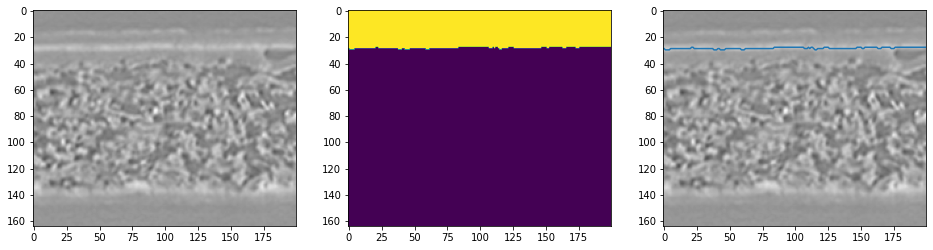

In [21]:
segmentations = [builder.what_segments(l).astype(np.int32) for l in layers]
segmentation_lines = [np.argmin(s, axis=0) - 0.5 for s in segmentations]
helpers.display_results(image_data, segmentations, segmentation_lines)

### 2.2 Detecting multiple layers

Now let's try to detect multiple layers.

We can visually see at least three layers we want to detect. All of these layers lie along the bright regions of the image. So we can begin by trying to use the same cost map from before in 3 separate layers.

In [22]:
n_layers = 3 # Detecting 3 layers

# Create a MaxFlowBuilder object
builder = MaxflowBuilder()

# Create a list of GraphObject layers using our image
layers = []
for i in range(n_layers):
    layers.append(GraphObject(cost_map))
builder.add_objects(layers)

# Add boundary costs
builder.add_layered_boundary_cost()

# Add a smoothness requirement
builder.add_layered_smoothness(delta=1)

# Find the maximum flow
flow = builder.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 287406


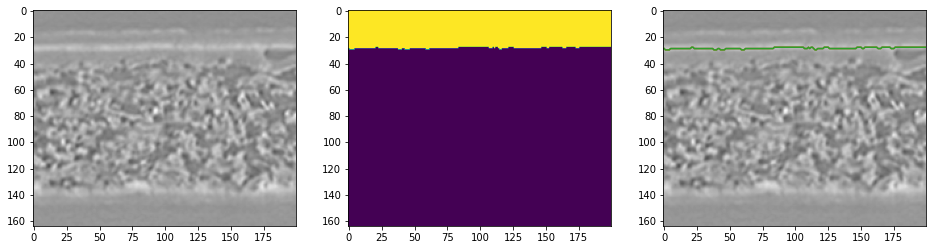

In [23]:
segmentations = [builder.what_segments(l).astype(np.int32) for l in layers]
segmentation_lines = [np.argmin(s, axis=0) - 0.5 for s in segmentations]
helpers.display_results(image_data, segmentations, segmentation_lines)

As you can see above, the 3 layers detected by the algorithm are all the same. To fix this we can add some constraints to force the layers to have a minimum distance apart.

### 2.3 Adding constraints
To start with we begin by setting up the MaxflowBuilder in the same way as before.

In [131]:
n_layers = 3 # Detecting 3 layer

# Create a MaxFlowBuilder object
builder = MaxflowBuilder()

# Create a list of GraphObject layers using our image
layers = []
for i in range(n_layers):
    layers.append(GraphObject(cost_map))
builder.add_objects(layers)

# Add boundary costs
builder.add_layered_boundary_cost()

# Add a smoothness requirement
builder.add_layered_smoothness(delta=1)

Looking at the image, we can see that the distance between the first and second layers is about 110 pixels. Layers are order from bottom to top. Therefore we want to define min_margin and max_margin constraints such that the distance between the two layers is constrained to 110 pixels. We can do this by setting the min_margin to 100 and max_margin to 110 using the line below.

In [132]:
builder.add_layered_containment(layers[0], layers[1], min_margin=105, max_margin=115)

Since there are three layers we would like to find, we need to set another constraint between the middle and top layers. It is not required to use both the min_margin and max_margin values. This time we will simply set the min_margin to 10 between the middle and top layers.

In [133]:
builder.add_layered_containment(layers[1], layers[2], min_margin=10)

Now we can solve the builder and display the result.

In [134]:
# Find the maximum flow
flow = builder.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 293316


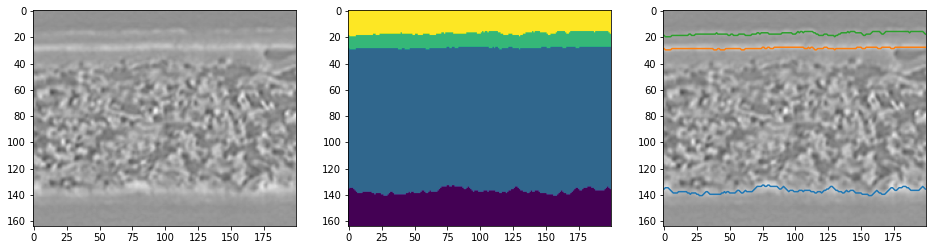

In [135]:
segmentations = [builder.what_segments(l).astype(np.int32) for l in layers]
segmentation_lines = [np.argmin(s, axis=0) - 0.5 for s in segmentations]
helpers.display_results(image_data, segmentations, segmentation_lines)

That brings us to the end of this tutorial. If you would like to experiment with your own data I have assembled the important functions into section 3 below. 

This tutorial notebook was written by William Laprade for the QIM group. If you have any questions you may contact me via email at wl@di.ku.dk.

## 3 Experiment with your own data

If you would like to experiment with your own data you can upload an image here and try these methods.

### 3.1 Load your data

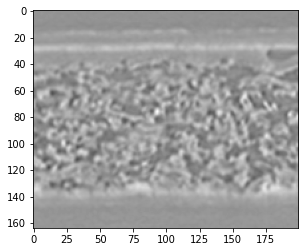

In [24]:
# File path to image
image_data = imread('data/layer2D.png').astype(np.int32)

# Display image
plt.imshow(image_data, cmap='gray', vmin=0, vmax=255)
plt.show()

### 3.2 Region mean estimator tool
If you need to estimate region means, you can use the estimator tool.

In [25]:
estimator_tool = helpers.MeanEstimatorTool(image_data)

interactive(children=(IntSlider(value=20, description='Brush size', max=20, min=2), Output()), _dom_classes=('…

Button(description='Calculate mean', style=ButtonStyle())

Button(description='Clear', style=ButtonStyle())

MultiCanvas(height=164, width=200)

### 3.3 Create the cost maps

In [27]:
# Add code for generating your cost maps here.
# The two methods we talked about are here for reference, you are welcome to use your own method as well.

# Using the region means formula
# region_means = [132.6561, 123.9585, 134.2254]
# n_layers = len(region_means)
# cost_maps = []
# for i in range(n_layers):
#     cost_map = (image_data - region_means[i]) ** 2
#     cost_maps.append(cost_map)

# Inverted image
cost_maps = []
for i in range(n_layers):
    cost_map = 255 - image_data
    cost_maps.append(cost_map)

View the cost maps.

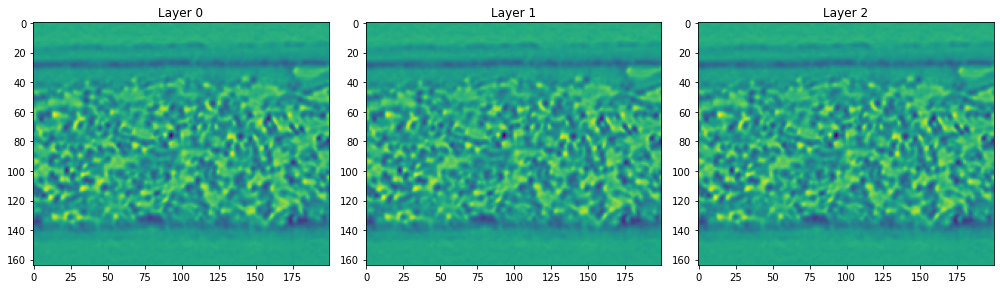

In [28]:
cols = 3
rows = int(np.ceil(n_layers / cols))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize=(14,10))
for i in range(n_layers):
    ax = fig.add_subplot(gs[i])
    ax.set_title(f'Layer {i}')
    ax.imshow(cost_maps[i])
    
fig.tight_layout()

### 3.4 Use the layer surface tool and detect the layers

In [34]:
# Create a MaxFlowBuilder object
builder = MaxflowBuilder()

# Create a list of GraphObject layers using our image
layers = []
for i in range(n_layers-1):
    layers.append(GraphObject(cost_maps[i]))
builder.add_objects(layers)

# Add region cost layers
for i in range(n_layers-1):
    builder.add_layered_region_cost(layers[i], cost_maps[i], cost_maps[i+1])
    
# Add boundary costs
builder.add_layered_boundary_cost()

# Add a smoothness requirement
builder.add_layered_smoothness(delta=1)

# Add constraints to the distance between the layers if you have more than 1 boundaries to segment
# builder.add_layered_containment(layers[0], layers[1], min_margin=0, max_margin=150)

# Find the maximum flow
flow = builder.solve()
print('Maximum flow/minimum energy:', flow)

Maximum flow/minimum energy: 191604


### 3.5 Display results

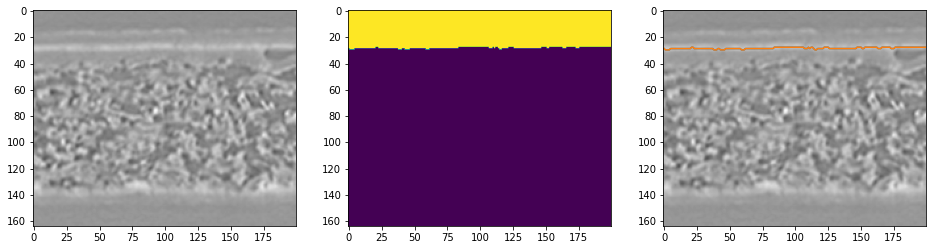

In [32]:
segmentations = [builder.what_segments(l).astype(np.int32) for l in layers]
segmentation_lines = [np.argmin(s, axis=0) - 0.5 for s in segmentations]
helpers.display_results(image_data, segmentations, segmentation_lines)